In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from gwaxion import physics
import pandas as pd
from matplotlib import ticker

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)

/home/misi/.local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/misi/.local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/misi/.local/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/misi/.local/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/home/misi/.local/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary inco

In [2]:
# create an array of BH masses

distance = 5E6 * physics.PC_SI
mbhs = np.linspace(1, 1000, 10)
chis = np.linspace(0.5, 0.9, 5)

rows = []
for mbh in mbhs:
    for chi in chis:
        bh = physics.BlackHole(mass=mbh, chi=chi, msun=True)
        h0s, fgws, alphas = bh.scan_alphas(alpha_max=0.5, delta_alpha=0.001)
        row = {
            'mbh': mbh,
            'h0_max': h0s.max(),
            'fgw_max': fgws[np.where(h0s==h0s.max())][0],
            'chi': chi,
        }
        rows.append(row)
df = pd.DataFrame(rows)

print df.head()

   chi       fgw_max    h0_max  mbh
0  0.5   7483.891561  0.000006  1.0
1  0.6   9281.879684  0.000027  1.0
2  0.7  11329.960892  0.000098  1.0
3  0.8  13750.582834  0.000323  1.0
4  0.9  16786.468630  0.001001  1.0


In [3]:
from matplotlib import cm

cs = [cm.magma(x) for x in np.linspace(0.1, 0.8, len(chis))]
lws = np.linspace(1, 4, len(chis))

/home/misi/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


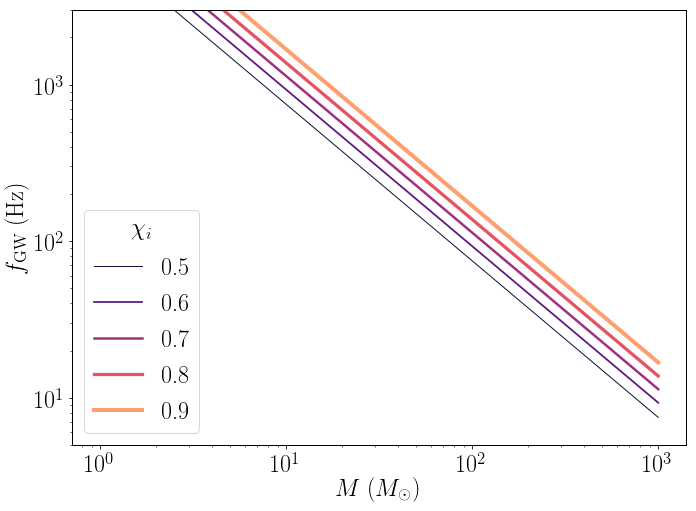

In [4]:
grouped = df.groupby('chi')

fig, ax = plt.subplots(1, figsize=(11,8))

for chi, c, lw in zip(chis, cs, lws):
    df_chi = grouped.get_group(chi)
    ax.plot(df_chi['mbh'], df_chi['fgw_max'], label="%.1f" % chi, lw=lw, c=c)

ax.set_xlabel(r'$M$ ($M_\odot$)')
ax.set_ylabel(r'$f_{\rm GW}$ (Hz)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower left', title=r"$\chi_i$")
plt.ylim(5, 3E3)

plt.show(ax)
plt.close()

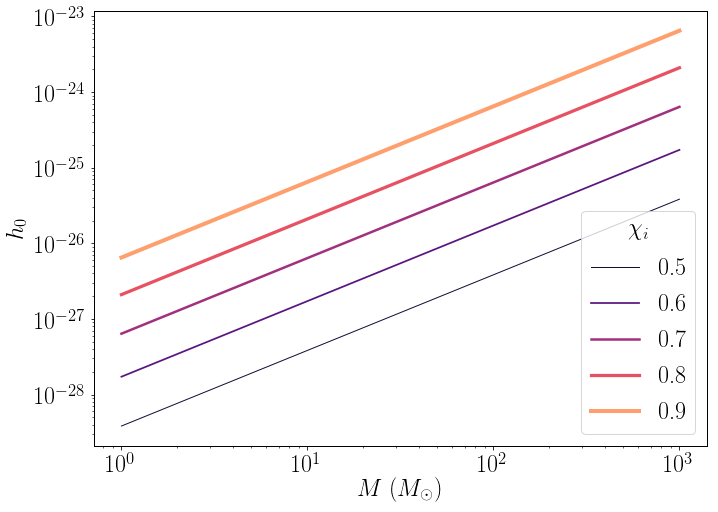

In [5]:
fig, ax = plt.subplots(1, figsize=(11,8))
for chi, c, lw in zip(chis, cs, lws):
    df_chi = grouped.get_group(chi)
    ax.plot(df_chi['mbh'], df_chi['h0_max']/distance, label="%.1f" % chi, lw=lw, c=c)

ax.set_xlabel(r'$M$ ($M_\odot$)')
ax.set_ylabel(r'$h_0$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='lower right', title=r"$\chi_i$")

plt.show(ax)
plt.close()

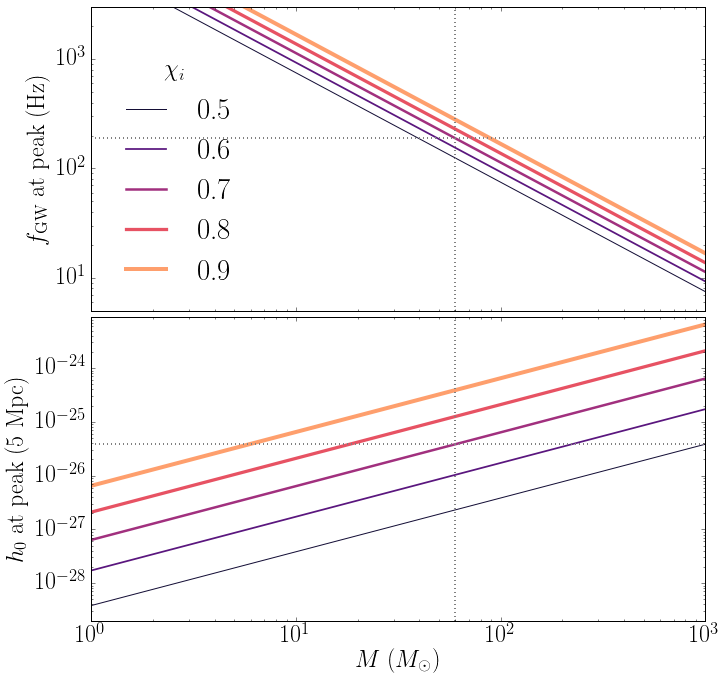

In [120]:
# joint plot

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(11,11))

for chi, c, lw in zip(chis, cs, lws):
    df_chi = grouped.get_group(chi)

    ax1.plot(df_chi['mbh'], df_chi['fgw_max'], label="%.1f" % chi, lw=lw, c=c)
    ax2.plot(df_chi['mbh'], df_chi['h0_max']/distance, label="%.1f" % chi, lw=lw, c=c)

plt.subplots_adjust(wspace=0, hspace=0.02)
    
ax2.set_xlabel(r'$M$ ($M_\odot$)')
ax2.set_ylabel(r'$h_0$ at peak (5 Mpc)')
ax1.set_ylabel(r'$f_{\rm GW}$ at peak (Hz)')
ax1.set_ylim(5, 3E3)
ax2.set_ylim(2E-29, 9E-24)

for ax in [ax1, ax2]:
    ax.axvline(60, lw=2, c='gray', ls=':')
    ax.set_xscale('log')
    ax.set_yscale('log')

ax1.axhline(188.93913803, lw=2, c='gray', ls=':')
ax2.axhline(3.82699460604e-26, lw=2, c='gray', ls=':')
    
ax1.legend(loc='lower left', title=r"$\chi_i$", frameon=False)

fig.savefig("plot_peak_mbh_chi.pdf", bbox_inches='tight')

plt.show(ax)
plt.close()


## Colormap

In [9]:
# create an array of BH masses

n_mass = 5000
n_chi = 1000
n_alpha = 2000

distance = 5E6 * physics.PC_SI

mbhs_array = np.linspace(1, 1E4, n_mass)
chis_array = np.linspace(1E-4, 1, n_chi)

alphas = np.linspace(0, 0.5, n_alpha)

df_list = []


dfpath = 'peak.hdf5'
if os.path.exists(dfpath):
    df_max = pd.read_hdf(dfpath, 'table', mode='r')
else:
    rows = []
    for mbh in mbhs_array:
        for chi in chis_array:
            h0s, fgws = physics.h0_scalar_brito(mbh, alphas, chi_i=chi, d=distance)
            hmax = np.nanmax(h0s)
            fmax = fgws[h0s==hmax][0]
            amax = alphas[h0s==hmax][0]
            rows.append({'mbh': mbh, 'chi': chi, 'h0': hmax, 'fgw': fmax, 'alpha': amax})
    df_max = pd.DataFrame(rows)
    df_max.to_hdf('peak.hdf5', 'table', mode='w')

/home/misi/.local/lib/python2.7/site-packages/tables/__init__.py:93: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .utilsextension import (
/home/misi/.local/lib/python2.7/site-packages/tables/file.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import hdf5extension
/home/misi/.local/lib/python2.7/site-packages/tables/link.py:33: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import linkextension
/home/misi/.local/lib/python2.7/site-packages/tables/table.py:28: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import tableextension
/home/misi/.local/lib/python2.7/site-packages/tables/index.py:33: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import indexesextension


In [10]:
print df_max.head()
print df_max.tail()

     alpha       chi        fgw            h0  mbh
0  0.00025  0.000100  16.164330 -2.084442e-49  1.0
1  0.00025  0.001101  16.164334  2.324040e-50  1.0
2  0.00050  0.002102  32.328668  2.983916e-48  1.0
3  0.00075  0.003103  48.493001  5.114043e-47  1.0
4  0.00075  0.004104  48.493038  5.568913e-46  1.0
            alpha       chi       fgw            h0      mbh
4999995  0.325163  0.995996  2.133077  2.110833e-22  10000.0
4999996  0.325913  0.996997  2.138113  2.135254e-22  10000.0
4999997  0.326913  0.997998  2.144597  2.159968e-22  10000.0
4999998  0.327914  0.998999  2.151085  2.184978e-22  10000.0
4999999  0.328664  1.000000  2.156135  2.210290e-22  10000.0


In [11]:
h0_bound = df_max[(df_max['mbh']>10) & (df_max['mbh']<1E3)]['h0']
print h0_bound.min()
print h0_bound.max()

-2.082565311167164e-46
2.2083002202496464e-23


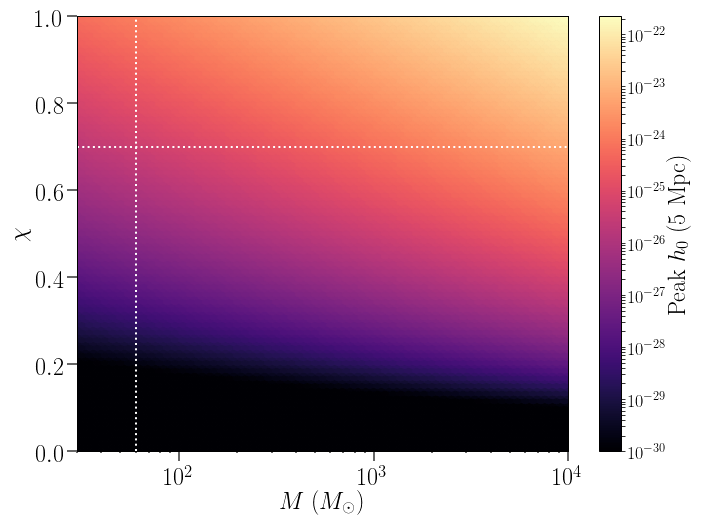

In [168]:
# colormap for peak h0 vs chi vs M

h0s = df_max['h0']
hmax_ma = np.ma.masked_array(h0s, mask=(h0s<=0)|(np.isnan(h0s)))

hmin, hmax = 1E-30, hmax_ma.max()
norm = matplotlib.colors.LogNorm(vmin=hmin, vmax=hmax)

fig, ax = plt.subplots(1, figsize=(11,8))

# plot contours
cm = ax.hexbin(df_max['mbh'], df_max['chi'], C=hmax_ma, cmap='magma', norm=norm,  xscale='log')

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'Peak $h_0$ (5 Mpc)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("grey")

plt.xlim(30, 1E4)
plt.ylim(0, 1)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

cm.set_rasterized(True)

fig.savefig('cmap_chi_mbh_h0max.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()


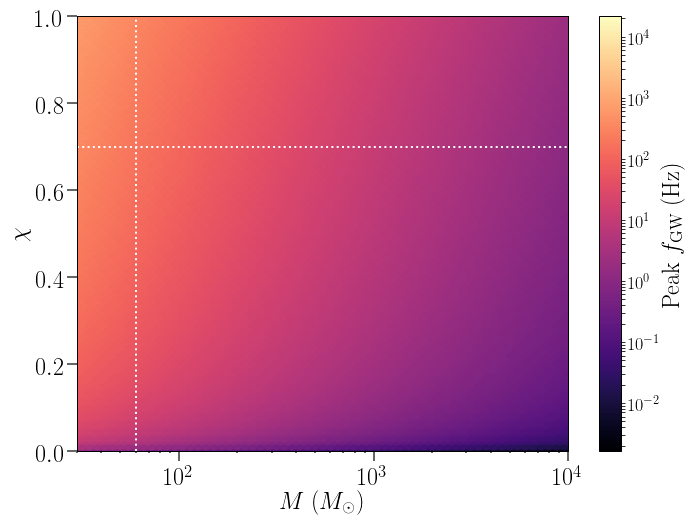

In [169]:
# colormap for peak fgw vs chi vs M

fs = df_max['fgw']
fmax_ma = np.ma.masked_array(fs, mask=(fs<=0)|(np.isnan(fs)))

fmin, fmax = fmax_ma.min(), fmax_ma.max()
norm = matplotlib.colors.LogNorm(vmin=fmin, vmax=fmax)

fig, ax = plt.subplots(1, figsize=(11,8))

# plot contours
cm = ax.hexbin(df_max['mbh'], df_max['chi'], C=fmax_ma, cmap='magma', norm=norm,  xscale='log')

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'Peak $f_{\rm GW}$ (Hz)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("grey")

plt.xlim(30, 1E4)
plt.ylim(0, 1)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

cm.set_rasterized(True)

fig.savefig('cmap_chi_mbh_fmax.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

## Range

The range is the source distance for which the peak amplitude at Earth is equal to our "minimum detectable" one:

$d_{\rm max} = \frac{h^{\rm max}_0}{h^{95}_0} d_{\rm ref} $ and $h^{95}_0(f) = h^{95}_{\rm ref} \sqrt{\frac{S_{\rm ref}}{S(f)}} \sqrt{\frac{T_{\rm ref}}{T}}$

In [12]:
# From Lilli: 95% detection efficiency h0 is 4.7e-26 at 201.2 Hz and an ASD of 4E-24 Sqrt[Hz], for T=80 days

h95ref = 4.7E-26
f95ref = 201.2
asd95ref = 4E-24

from lal import DAYSID_SI
Tref = 80*DAYSID_SI

print "Reference values:"
print "\tDistance: %.1e PC" % (distance/physics.PC_SI)
print "\tObservation time: %.1e" % (Tref / DAYSID_SI)
print "\th95: %.1e" % h95ref
print "\tASD: %.1e" % asd95ref

def horizon(h0, f, T=Tref, href=h95ref, asdref=asd95ref, Tref=Tref, psd=None, asd=None, dref=distance):
    asd = asd if asd is not None else np.array([psd(freq)**0.5 for freq in np.array(f)])
    h95 = href * (asdref/asd) * (Tref/T)**0.5
    return h0 * dref / h95
    

Reference values:
	Distance: 5.0e+06 PC
	Observation time: 8.0e+01
	h95: 4.7e-26
	ASD: 4.0e-24


### aLIGO design

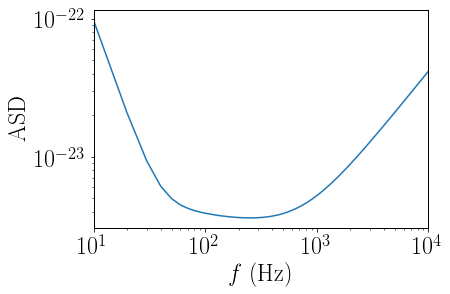

In [13]:
from lalsimulation import SimNoisePSDaLIGOZeroDetHighPower

flow = 10
fhig = 1E4
freqs = np.linspace(flow, fhig, 1000)

psd = np.array([SimNoisePSDaLIGOZeroDetHighPower(f) for f in freqs])
asd = psd**0.5

fig, ax = plt.subplots(1)
ax.plot(freqs, asd)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(flow, fhig)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

In [14]:
dfm = df_max[(df_max['h0']>0) & (~np.isnan(df_max['h0']) & (df_max['fgw']>0))].copy()

dfm['dmax_design'] = horizon(dfm['h0'], dfm['fgw'], psd=SimNoisePSDaLIGOZeroDetHighPower)

print dfm['dmax_design'].min()
print dfm['dmax_design'].max()

0.6275868175232939
6.691832117405732e+29


In [15]:
# get horizon
from gwaxion.horizon import find_horizon_range

horizon = find_horizon_range(0.5*dfm['mbh'], 0.5*dfm['mbh'], asdfile=[freqs, asd])


TypeError: buffer size mismatch

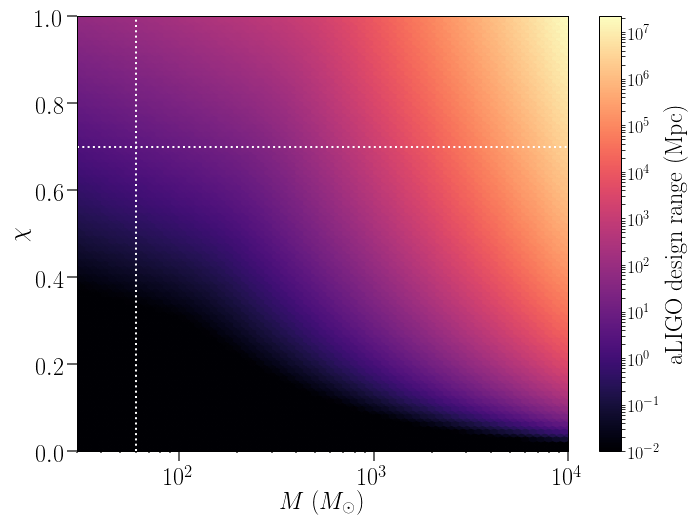

In [174]:
# colormap for peak h0 vs chi vs M

from matplotlib import ticker

#d = np.ma.masked_array(dfm['dmax_design'], dfm['dmax_design']<1E-3)
d = dfm['dmax_design'] / (1E6 * physics.PC_SI)
dmin, dmax = 1E-2, d.max()
norm = matplotlib.colors.LogNorm(vmin=dmin, vmax=dmax)

fig, ax = plt.subplots(1, figsize=(11,8))

# plot contours
cm = ax.hexbin(dfm['mbh'], dfm['chi'], C=d, cmap='magma', norm=norm,  xscale='log')

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'aLIGO design range (Mpc)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("grey")

plt.xlim(30, 1E4)
plt.ylim(0, 1)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

cm.set_rasterized(True)

fig.savefig('cmap_chi_mbh_range-design.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

### 3G detectors

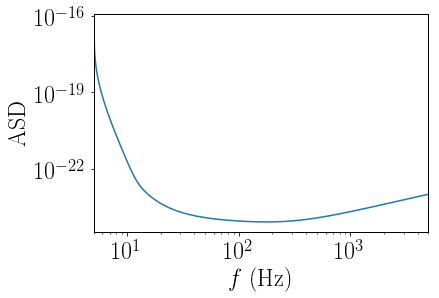

5.0 5000.0


In [157]:
# load Voyager ASD
vals = np.loadtxt('noise_curves_T1500293-v10/voyager.txt')
freqs, asd_voy_array = vals[:,0], vals[:,1]

# create interpolant
from scipy.interpolate import interp1d

asdv = interp1d(freqs, asd_voy_array)

fmin, fmax = freqs.min(), freqs.max()

asd = asdv(freqs)

fig, ax = plt.subplots(1)
ax.plot(freqs, asd)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

print fmin, fmax

In [154]:
# remove freqs outside interp range
dfmv = dfm[(dfm['fgw']>fmin) & (dfm['fgw']<fmax)].copy()
dfmv['dmax_voyager'] = horizon(dfmv['h0'], dfmv['fgw'], asd=asdv(dfmv['fgw'].values))

print dfmv['dmax_voyager'].min()
print dfmv['dmax_voyager'].max()

4.528614153283292
3.6102257959108854e+33


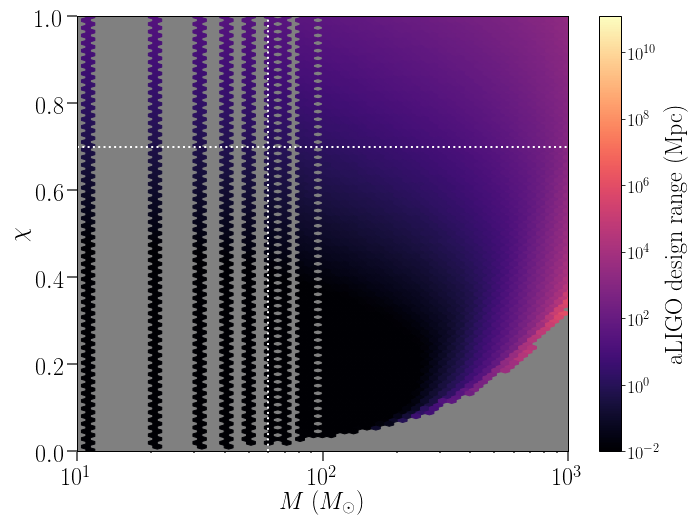

In [158]:
# colormap for peak h0 vs chi vs M

from matplotlib import ticker

#d = np.ma.masked_array(dfm['dmax_design'], dfm['dmax_design']<1E-3)
d = dfmv['dmax_voyager'] / (1E6 * physics.PC_SI)
dmin, dmax = 1E-2, d.max()
norm = matplotlib.colors.LogNorm(vmin=dmin, vmax=dmax)

fig, ax = plt.subplots(1, figsize=(11,8))

# plot contours
cm = ax.hexbin(dfmv['mbh'], dfmv['chi'], C=d, cmap='magma', norm=norm,  xscale='log')

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'aLIGO design range (Mpc)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("grey")

plt.xlim(10, 1E3)
plt.ylim(0, 1)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

cm.set_rasterized(True)

#fig.savefig('cmap_chi_mbh_h0max.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()